## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner_py3 as miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [66]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','GitHub','miner','miner')

# create name for results folder where output files will be saved
resultsFolder = "results_miner3_stabilized"

# name of the folder containing the miner network
networkFolder = "miner_network_results"
#networkFolder = "results_minCorrelation_0o2_50_allFiles"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load primary data

In [67]:
# Load expression Data
expressionFile = os.path.join(input_path,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

completed identifier conversion.
16216 genes were converted.


## Load network

In [68]:
# Load Causal Mechanistic Network
filtered_causal_results = pd.read_csv(os.path.join(input_path,networkFolder,"filteredCausalResults.csv"),index_col=0,header=0)

In [69]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [70]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

## Load primary survival data

In [41]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(input_path,"data","survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Figures

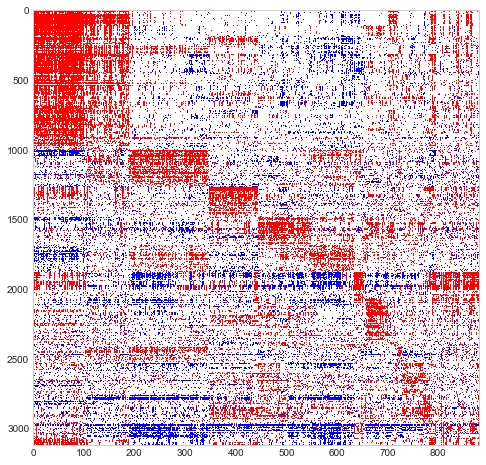

In [71]:
# Regulon activity heatmap
plt.figure(figsize=(8,8))
plt.imshow(diff_matrix_MMRF.loc[np.hstack(program_list),np.hstack(states_list)],
          cmap="bwr",vmin=-1,vmax=1,aspect=0.275)
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),bbox_inches="tight")

## Survival analysis of transcriptional programs

In [72]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes

In [73]:
# Cox proportional hazards regression of transcriptional programs
cox_programs = []
cox_keys = []
for key in list(pr_genes.keys()):
    cluster = np.array(expressionData.loc[pr_genes[key],:])
    median_ = np.mean(cluster,axis=0)
    median_df = pd.DataFrame(median_)
    median_df.index = expressionData.columns
    median_df.columns = [key]

    cox_results_ = miner.survivalMedianAnalysisDirect(median_df,guanSurvivalDfMMRF)
    cox_keys.append(key)
    cox_programs.append([cox_results_[key][0],cox_results_[key][1]])

cox_output = pd.DataFrame(np.vstack(cox_programs))
cox_output.index = cox_keys
cox_output.columns = ['HR','p-value']
cox_output = cox_output.iloc[np.argsort(np.array(cox_output.index).astype(int))]
cox_output.to_csv(os.path.join(resultsDirectory,'CoxProportionalHazardsPrograms.csv'))
cox_output.sort_values(by="HR",ascending=False,inplace=True)

print("\nHigh-risk programs:")
print(cox_output.iloc[0:5,:])
print("\nLow-risk programs")
print(cox_output.iloc[-5:,:])


High-risk programs:
           HR       p-value
67   8.881874  6.574349e-19
71   7.348079  2.010754e-13
147  5.724236  1.039000e-08
127  5.455855  4.873774e-08
140  5.054404  4.317361e-07

Low-risk programs
           HR   p-value
124 -4.353958  0.000013
9   -4.592126  0.000004
116 -4.636098  0.000004
109 -4.642906  0.000003
40  -4.715939  0.000002


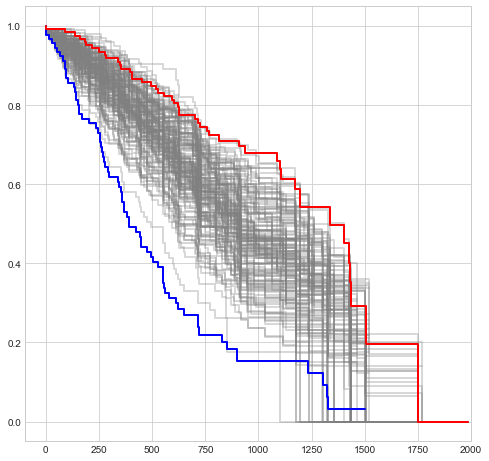

In [74]:
# Kaplan-Meier plot of all programs (median expression)
srv = guanSurvivalDfMMRF.copy()
keys = list(pr_genes.keys())

plt.figure(figsize=(8,8))
plt.style.use('seaborn-whitegrid')
plt.xlim(-100,2000)
for key in keys:
    cluster = np.array(expressionData.loc[pr_genes[key],:])
    median_ = np.mean(cluster,axis=0)
    threshold = np.percentile(median_,85)
    median_[median_>=threshold] = 1
    median_[median_<threshold] = 0
    median_df = pd.DataFrame(median_)
    median_df.index = expressionData.columns
    median_df.columns = [key]

    cox_hr, cox_p = miner.survivalMembershipDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]
    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="gray",alpha=0.3)  


key_min = 67
key_max = 40

cluster = np.array(expressionData.loc[pr_genes[key_min],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
median_df = pd.DataFrame(median_)
median_df.index = expressionData.columns
median_df.columns = [key_min]

cox_hr, cox_p = miner.survivalMembershipDirect(median_df,guanSurvivalDfMMRF)

groups = [median_df.index[np.where(median_df[key_min]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="blue",alpha=1)  

    
cluster = np.array(expressionData.loc[pr_genes[key_max],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
median_df = pd.DataFrame(median_)
median_df.index = expressionData.columns
median_df.columns = [key_max]

cox_hr, cox_p = miner.survivalMembershipDirect(median_df,guanSurvivalDfMMRF)

groups = [median_df.index[np.where(median_df[key_max]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="red",alpha=1) 

plt.savefig(os.path.join(resultsDirectory,"kmplots_programs.pdf"),bbox_inches="tight")

## Survival analysis of transcriptional programs

/anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:920: ConvergenceWarning: Column 16 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['observed'].astype(bool)
>>> print(df.loc[events, '16'].var())
>>> print(df.loc[~events, '16'].var())

A very low variance means that the column 16 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


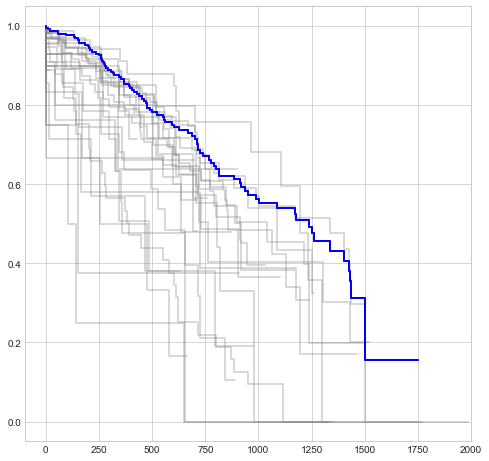

In [75]:
# Kaplan-Meier plot of all programs (median expression)
plt.figure(figsize=(8,8))
plt.style.use('seaborn-whitegrid')
plt.xlim(-100,2000)

srv = guanSurvivalDfMMRF.copy()
for key in range(len(states_list)):

    median_df = pd.DataFrame(np.zeros(expressionData.shape[1]))
    median_df.index = expressionData.columns
    median_df.columns = [key]
    median_df.loc[states_list[key],key] = 1

    cox_hr, cox_p = miner.survivalMembershipDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="gray",alpha=0.3,fs=20)  


highlight_list = [
                 np.hstack([states_list[0],states_list[1],states_list[2],states_list[3]])]

for key in range(len(highlight_list)):
    median_df = pd.DataFrame(np.zeros(expressionData.shape[1]))
    median_df.index = expressionData.columns
    median_df.columns = [key]
    median_df.loc[highlight_list[key],key] = 1

    cox_hr, cox_p = miner.survivalMembershipDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="red",alpha=1,fs=20)  
    
# Combine high-risk states
highlight_list = [
                 np.hstack([states_list[0],states_list[1],states_list[2],states_list[3]])]

for key in range(len(highlight_list)):
    median_df = pd.DataFrame(np.zeros(expressionData.shape[1]))
    median_df.index = expressionData.columns
    median_df.columns = [key]
    median_df.loc[highlight_list[key],key] = 1

    cox_hr, cox_p = miner.survivalMembershipDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="blue",alpha=1,fs=20)  
    
plt.savefig(os.path.join(resultsDirectory,"kmplots_states.pdf"),bbox_inches="tight")

## Generate boxplot data for transcriptional states

In [76]:
survival_patients = list(guanSurvivalDfMMRF.index)
t414_patients = translocations.columns[
    np.where(translocations.loc["RNASeq_WHSC1_Call",:]==1)[0]
]
t1114_patients = translocations.columns[
    np.where(translocations.loc["RNASeq_CCND1_Call",:]==1)[0]
]

min_patients = 5
ranks = []
boxplot_data = []
boxplot_names = []
boxplot_samples = []
boxplot_labels = []
percent_t414 = []
percent_t1114 = []
for key in range(len(states_list)):
    state = states_list[key]
    overlap_patients = list(set(survival_patients)&set(state))
    if len(overlap_patients) < min_patients:
        continue
    guan_data = list(guanSurvivalDfMMRF.loc[overlap_patients,"GuanScore"])
    boxplot_samples.append(overlap_patients)
    boxplot_data.append(guan_data)
    boxplot_names.append([1+key for i in range(len(overlap_patients))])
    risk_score = np.median(guan_data)
    ranks.append(risk_score)
    
    t414_overlap = len(set(state)&set(t414_patients))
    t1114_overlap = len(set(state)&set(t1114_patients))
    percent_t414_ = float(t414_overlap)/len(state)
    percent_t1114_ = float(t1114_overlap)/len(state)
    percent_t414.append(percent_t414_)
    percent_t1114.append(percent_t1114_)
ranks            

labels = np.hstack(np.array(boxplot_names)[np.argsort(ranks)])
labels_df = pd.DataFrame(labels)
labels_df.index = np.hstack(np.array(boxplot_samples)[np.argsort(ranks)])
labels_df.columns = ["label"]
plot_data = pd.concat([guanSurvivalDfMMRF.loc[labels_df.index,"GuanScore"],labels_df],axis=1)

rank_order = np.array(list(set(np.hstack(boxplot_names))))[np.argsort(ranks)]
ranked_t414 = np.array(percent_t414)[np.argsort(ranks)]
ranked_t1114 = np.array(percent_t1114)[np.argsort(ranks)]

## Violin plots by states

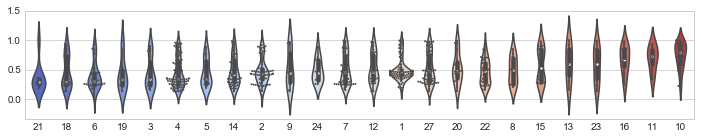

In [77]:
f, ax = plt.subplots(figsize=(12, 2))

# Plot the orbital period with horizontal boxes
sns.violinplot(x="label", y="GuanScore", data=plot_data,fliersize=0,
            palette="coolwarm",order=rank_order)

# Add in points to show each observation
sns.swarmplot(x="label", y="GuanScore", data=plot_data,
              size=2, color=".3", linewidth=0,order=rank_order)

# Tweak the visual presentation
ax.set(ylabel="")
ax.set(xlabel="")
#ax.set(ylim=(-0.4,1.4))

# Save figure
plt.savefig(os.path.join(resultsDirectory,"violin_states_risk.pdf"),bbox_inches="tight")

## Boxplots by states

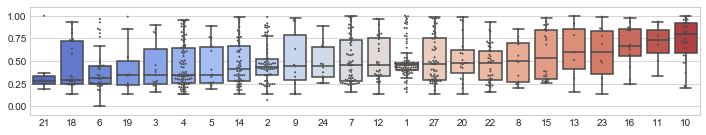

In [78]:
f, ax = plt.subplots(figsize=(12, 2))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="label", y="GuanScore", data=plot_data,fliersize=0,
            palette="coolwarm",order=rank_order)

# Add in points to show each observation
sns.swarmplot(x="label", y="GuanScore", data=plot_data,
              size=2, color=".3", linewidth=0,order=rank_order)

# Tweak the visual presentation
ax.set(ylabel="")
ax.set(xlabel="")
ax.set(ylim=(-0.1,1.1))

# Save figure
plt.savefig(os.path.join(resultsDirectory,"boxplot_states_risk.pdf"),bbox_inches="tight")

## t(4;14) and t(11;14) subtypes by states

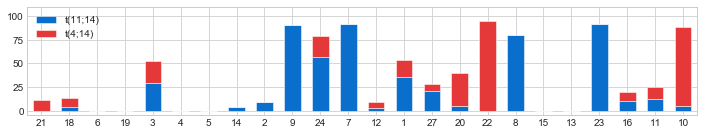

In [79]:
plt.figure(figsize=(12, 2))

N = len(ranks)
ind = np.arange(N)    # the x locations for the groups
w = 0.6
p1 = plt.bar(ind, 100*ranked_t1114,width=w,color='#0A6ECC',edgecolor="white",alpha=1)
p2 = plt.bar(ind, 100*ranked_t414,
             bottom=100*ranked_t1114,width=w,color='#E53939',edgecolor="white",alpha=1)

plt.xlim(-0.5,N-0.5)
plt.ylim(-5,110)
plt.xticks(ticks=range(len(rank_order)),labels=list(rank_order))
plt.legend((p1[0], p2[0]), ('t(11;14)', 't(4;14)'),loc="upper left")

plt.savefig(os.path.join(resultsDirectory,"barplot_states_translocations.pdf"),bbox_inches="tight")